In [1]:
#Carga de las librerias
import nilmtk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nilmtk.dataset_converters import convert_redd

In [2]:
#Carga de los datos en memoria
from nilmtk import DataSet
from nilmtk.utils import print_dict
directorio = ('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
redd = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5') #Puede cargarlo como csv

In [3]:
#Función para seleccionar activaciones y guardarlas en archivos
def seleccion_activaciones(id_edificio = 1, 
                           ruta_guardar = "C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\huellas_red_LF\\building1\\"):
    #1.Cargar dispositivos del edificio
    dispositivos = redd.buildings[id_edificio].elec
    #2. Recorrer las instancias de cada edificio
    i = 3     #Instancias los dispositivos en el edificio ignora los medidores centrales
    op = True #Si no existe el dispositivo termina el ciclo de carga 
    while(op):
        try:
            print(f"Se cargo el dispositivo {i}")
            #Selecciono un dispositivo por instancia
            dispositivo = dispositivos[i]     
            #Extraigo las activaciones
            activaciones = dispositivo.get_activations(on_power_threshold = 10)
            #Mediante un ciclo extraigo los instantes de inicio y fin de cada activación
            #Estos datos los guardo en una lista 
            huellas = []
            for j in range(len(activaciones)):
                inicio = activaciones[j].index[0]             
                fin    = activaciones[j].index[len(activaciones[j])-1]
                dato = [inicio, fin]
                huellas.append(dato)
            #Cambiar el archivo a df para cambiar el nombre de columnas y guardarlo
            huellas = pd.DataFrame(huellas)
            huellas.rename(columns={0:'inicio', 1:'fin'}, inplace=True)
            #Guardar los archivos en la ruta y con el nombre de la instancia
            #huellas.to_csv(ruta_guardar+"instancia_"+i+".csv", sep=r" ", header= 0) 
            huellas.to_csv(ruta_guardar+"instancia_"+str(i)+".csv", sep=r" ", header= 0)
            i += 1
        except:
            op = False
            print(f"Fin de carga la instancia {i} no existe")    

In [5]:
#Direcciones donde se guardaran las activaciones por edificio y dispositivo
dir = ["C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\huellas_red_LF\\building1\\", 
       "C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\huellas_red_LF\\building2\\", 
       "C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\huellas_red_LF\\building3\\", 
       "C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\huellas_red_LF\\building4\\", 
       "C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\huellas_red_LF\\building5\\", 
       "C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\huellas_red_LF\\building6\\"]

In [ ]:
#Recorrer la función de busqueda de activaciones para los seis edificios
for k in range(1,7):
    direccion = dir[k-1]
    seleccion_activaciones(k, direccion)

In [ ]:
#**************************************************

In [ ]:
#Cargar los datos sin procesar para cada dispositivo
#c1_dishwaser = pd.read_csv('C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building1//elec//meter6.csv', 
#                              header=[0,1])#, index_col=0)
#c1_dishwaser = c1_dishwaser.iloc[0:,:].values
#c1_dishwaser = pd.DataFrame(c1_dishwaser)
#c1_dishwaser.rename(columns={0:'time', 1:'power'}, inplace=True)

#Cambiar a datos en formato de tiempo
#c1_dishwaser['time'] = pd.to_datetime(c1_dishwaser['time'])
#c1_dishwaser.set_index('time', inplace= True)
#c1_dishwaser

In [ ]:
#**************************************************

## Seleccionar los intervalos donde el medidor central funciona bien

In [6]:
def tiempos_buen_funcionamiento(id_edificio = 1, 
                        ruta_guardar = "C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\huellas_red_LF\\building1\\",
                       graficar = False, guardar = False):
    #Cargar los dispositivos por cada edificio
    dispositivos = redd.buildings[id_edificio].elec
    #Los tiempos se guardaran en una lista
    tiempos = []
    #Buscar los tiempos de funcionamiento de los 2 medidores central
    for i in range(1,3):
        #Seleccionar el medidor
        medidor = dispositivos.mains()[i]
        #Extraer los tiempos
        good_sections_medidor = medidor.good_sections(full_results=True)
        good_sections_medidor.timeframes()
        #Graficarlos
        if(graficar): good_sections_medidor.plot()
        
        #Extraer todos los tiempos los tiempos
        tiempos_medidor = good_sections_medidor.combined()
        
        #Guardar datos
        if(guardar):
            df = pd.DataFrame(tiempos_medidor)
            #df.rename(columns={0:'inicio', 1:'fin'}, inplace=True)
            df.to_csv(ruta_guardar+"tiempos_buen_medidor_"+str(i)+".csv", sep=r" ", header= 0)
        
        #Unir los dos tiempos en una sola lista
        tiempos.append(tiempos_medidor)
        
    return tiempos

In [ ]:
#Guardamos todos los tiempos de buen funcionamiento de los medidores centrales de cada edificio
for i in range(1,7):
    tiempos_buen_funcionamiento(id_edificio = i, guardar = True)

In [ ]:
#t = tiempos_buen_funcionamiento()

## Dejar solo los tiempos de buen funcionamiento por medidor central

Con esta funcion comparamos el archivo original vs los tramos donde la libreria detecta que los medidores centrales funcionaron de manera adecuada. Eliminamos los tramos donde el sistema funciono de forma inadecuada

In [7]:
def medidas_buenas_en_medidores(id_edificio = 1,
                                ruta_guardar = "C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\huellas_red_LF\\building1\\",
                                
                                ruta_archivo_original = [
                                    'C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building1//elec//meter1.csv', 
                                    'C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building1//elec//meter2.csv']):
    #print(ruta_archivo_original)
    #Tomo los tiempos para los medidores centrales
    tiempos = tiempos_buen_funcionamiento(id_edificio = id_edificio)
    #Cargo los dos medidores originales por edificio
    for medidor in range(0,2):
        print(f"Edificio {id_edificio} medidor_{medidor}")
        #Medididor
        mean = pd.read_csv(rutas_archivos_originales[id_edificio-1][medidor],header=[0,1])#, index_col=0)
        #Tomar solo los valores
        mean = mean.iloc[0:,:].values        
        #Convertir a dataframe
        mean = pd.DataFrame(mean)
        #Cambiar el nombre de las columnas
        mean.rename(columns={0:'time', 1:'power'}, inplace=True)
        #Cambiar a datos en formato de tiempo que faciliten las busquedas de intervaloes
        mean['time'] = pd.to_datetime(mean['time'])
        mean.set_index('time', inplace= True)
        #print(f"Tamaño original datos {mean.shape}")
        #print("*******************")
        #plt.plot(mean)
                              
        #Concatenar en un nuevo archivo los datos en periodos de buen funcionamiento
        mean_nuevo = pd.DataFrame()
        #prueba = mean.copy()
        
        #Seleccionamos y concatenamos para cada intervalo por medio de cortes
        for muestra in range(len(tiempos[medidor])):
            #print(f"{medidor} Entro {muestra} de {len(tiempos[medidor])} {mean_nuevo.shape}")
            mean_nuevo = pd.concat([mean_nuevo.loc[:,:], 
                                    mean.loc[tiempos[medidor][muestra].start: tiempos[medidor][muestra].end]
                                   ])
        mean_nuevo.to_csv(ruta_guardar+"good_mean_"+str(medidor)+".csv", sep=r" ", header= 0)
        #print(f"Tamaño salida datos {mean_nuevo.shape}")

In [8]:
rutas_archivos_originales = [
    ['C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building1//elec//meter1.csv', 
    'C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building1//elec//meter2.csv', ],
    
    ['C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building2//elec//meter1.csv', 
    'C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building2//elec//meter2.csv', ],
    
    ['C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building3//elec//meter1.csv', 
    'C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building3//elec//meter2.csv', ],
    
    ['C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building4//elec//meter1.csv', 
    'C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building4//elec//meter2.csv', ],
    
    ['C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building5//elec//meter1.csv', 
    'C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building5//elec//meter2.csv', ],
    
    ['C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building6//elec//meter1.csv', 
    'C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building6//elec//meter2.csv', ]    
]

In [ ]:
#Crear archivos de buena medida para los medidores centrales de cada edificio
for i in range(1,7):
    medidas_buenas_en_medidores(id_edificio = i,   
                                ruta_guardar = dir[i-1],
                                ruta_archivo_original = rutas_archivos_originales[i-1]                                
                                )

## Crear las columnas con las marcas de funcionamiento por dispositivo
Se marcara con un uno los instantes de tiempo donde los dispositivos esten encendidos al mismo tiempo que en los puntos donde el medidor central registro una medida y con un cero cuando el dispositivo este apagado. 

En los trabajos que se han publicado lo que se hace es disgregar el consumo por dispositivo no se usa una etiqueta para indicar que el dispositivo esta encendido u apagado. 

Basicamente se hace una prediccion de los cambios de consumo en el medidor central y se intenta reconstruir la señal de consumo de dicho electrodomestico. 

Para ello se usa como puntos de salida los medidores individuales y despues se intenta reconstruir a la salida una señal con igual comportamiento. 

Se debe tener en cuenta que se deben igualar los periodos de muestreo entre los medidores centrales y los individuales

In [ ]:
#1.Cargar los datos de los medidores centrales
#2.Copiar el dato de tiempo en una columna
#3.Crear las columnas de etiquetas con los nombres de cada dispositivo
#4.Estas columnas deben ser inicialmente cero
#5.Por medio del tiempo inicial y final de cada dispositivo se marcara con uno
#los intantes donde esta encendido
#6.Unir las matrices de etiquetas a las de señales de los medidores
#Nota: Los dos medidores centrales comparten los timeStep 

In [ ]:
#1.Cargar los datos de los medidores centrales
#Edificio 1

In [9]:
#Ruta a las activaciones extraidas por dispositivo
pad_huellas=[
    "C://Users//josel//SmartMeter//OrdenandoTodo//huellas_red_LF//building1//",
    "C://Users//josel//SmartMeter//OrdenandoTodo//huellas_red_LF//building2//",
    "C://Users//josel//SmartMeter//OrdenandoTodo//huellas_red_LF//building3//",
    "C://Users//josel//SmartMeter//OrdenandoTodo//huellas_red_LF//building4//",
    "C://Users//josel//SmartMeter//OrdenandoTodo//huellas_red_LF//building5//",
    "C://Users//josel//SmartMeter//OrdenandoTodo//huellas_red_LF//building6//"
]

La siguiente función crea un df que tiene la columna de tiempo y para cada tiempo se marca una columna de dispositivo como activa 1 o inactiva 0, es un one hot encoding para los tiempos de medidor central de cada edificio. 

In [11]:
def marcas_de_activacion(id_edificio = 1, 
                         medidor = 0, 
                         rutas_archivos_originales = ['C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building1//elec//meter1.csv',
                                                      'C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building1//elec//meter2.csv'],
                         pad_huellas = "C://Users//josel//SmartMeter//OrdenandoTodo//huellas_red_LF//building1//"
                         
                        ):

    #1. Cargamos el archivo del medidor sin procesar
    mean = pd.read_csv(rutas_archivos_originales[medidor],header=[0,1])
    #Tomar solo los valores
    mean = mean.iloc[0:,:].values        
    #Convertir a dataframe
    mean = pd.DataFrame(mean)
    #Cambiar el nombre de las columnas
    mean.rename(columns={0:'time', 1:'power'}, inplace=True)
    #Cambiar a datos en formato de tiempo que faciliten las busquedas de intervalos
    mean['time'] = pd.to_datetime(mean['time'])
    mean.set_index('time', inplace= True)

    #2. Cargamos los nombres de los dispositivos por edificiopor defecto del edificio 1
    label = pd.read_csv(pad_huellas+"label.txt", header=None)
    print(label)
    #3. Creamos una matriz de ceros con una columna mas ademas de los dispositivos
    df = np.zeros([len(mean.index), len(label)+1], dtype = np.int8)
    #Lo cambio a un df de pandas
    df = pd.DataFrame(df)
    #Cambio el nombre de las columnas con los dispositivos
    nombre_columnas = {0:'time'}
    for i in range(1,len(label)):
        nombre_columnas[i] = label.iloc[i-1,0][10:]
    df.rename(columns=nombre_columnas, inplace=True)

    #Igualamos la columna de tiempo del df de etiquetas con las del medidor
    df['time'] = mean.index

    #Cambiar a datos en formato de tiempo que faciliten las busquedas de intervalos
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace= True)
    #print(df)
    
    #Ahora vamos a igualar a uno los instantes donde se activo un dispositivo
    #para eso usamos las huellas que se han separado antes
    

    #Cargamos las huella por dispositivo
    for nombre_dispositivo in range(len(label)):
    #for nombre_dispositivo in range(15,18):
        try:
            #Cargo los intervalos de tiempos de cada huella de dispositivo por edificio
            print(pad_huellas+label.iloc[nombre_dispositivo,0]+".csv")
            huella = pd.read_csv(pad_huellas+label.iloc[nombre_dispositivo,0]+".csv", 
                                 sep=r" ", header=None, index_col=0)

            #Ahora a la columna del primer dispositivo igualamos a uno donde conincidan los tiempos de activación
            #Selecciona la columna por dispositivo
            print(f"señales = {len(huella)}")
            for senal in range(len(huella)):            
                df.loc[huella.iloc[senal,0]:huella.iloc[senal,1],label.iloc[nombre_dispositivo,0][10:]] = 1
            #df.to_csv("etiquetas_edificio_"+str(id_edificio)+str(".csv"), header=0)
        except:
            print(f"Archivo {nombre_dispositivo} vacio")
            
    #Cambio el nombre de las columnas con los dispositivos
    df.rename(columns=nombre_columnas, inplace=True)
    df.to_csv("etiquetas_edificio_"+str(id_edificio)+str(".csv"), header=0)

In [ ]:
#marcas_de_activacion()

In [ ]:
#*****************************************
#Hacer el proceso para todos los edificios
for i in range(1,7):
    print(i)
    #Ejecutar el marcado para cada casa
    marcas_de_activacion(id_edificio = i,
                         medidor = 0,
                         rutas_archivos_originales = rutas_archivos_originales[i-1],
                         pad_huellas = pad_huellas[i-1])

In [12]:
rutas_archivos_originales[0]

['C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building1//elec//meter1.csv',
 'C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building1//elec//meter2.csv']

### Unir los df unidos para posteriormente unirlos como uno solo

Concatenamos en un solo df las etiquetas y las señales correspondientes a los medidores centrales de cada edificio

In [14]:
#Medidores centrales del edificio 1

#Medidor 1
medidor = 0
edificio = 0
mean_0 = pd.read_csv(rutas_archivos_originales[edificio][medidor],header=[0,1])
#Tomar solo los valores
mean_0 = mean_0.iloc[0:,:].values        
#Convertir a dataframe
mean_0 = pd.DataFrame(mean_0)
#Cambiar el nombre de las columnas
mean_0.rename(columns={0:'time', 1:'power'}, inplace=True)
#Cambiar a datos en formato de tiempo que faciliten las busquedas de intervalos
mean_0['time'] = pd.to_datetime(mean_0['time'])
mean_0.set_index('time', inplace= True)

#Medidor 2
medidor = 1
mean_1 = pd.read_csv(rutas_archivos_originales[edificio][medidor],header=[0,1])
#Tomar solo los valores
mean_1 = mean_1.iloc[0:,:].values        
#Convertir a dataframe
mean_1 = pd.DataFrame(mean_1)
#Cambiar el nombre de las columnas
mean_1.rename(columns={0:'time', 1:'power'}, inplace=True)
#Cambiar a datos en formato de tiempo que faciliten las busquedas de intervalos
mean_1['time'] = pd.to_datetime(mean_1['time'])
mean_1.set_index('time', inplace= True)

In [15]:
print(f"{mean_0.shape}")
print(f"{mean_1.shape}")

(1561660, 1)
(1561660, 1)


## Bases para AE
Mediante las huellas seleccionadas en C://Users//josel//SmartMeter//OrdenandoTodo//huellas_red_LF//buildin1//, ruta variable por edificio, vamos a tomar sola las huellas donde un dispositivo se encuentra encendido en su medidor central y mediante el extraer el mismo instante de tiempo de medidor central para encontrar un AE que pueda detectar la señal del dispositivo.

In [24]:
huellas_lf_casa_1 = 'C://Users//josel//SmartMeter//OrdenandoTodo//huellas_red_LF//'
edificio = ['building1//','buildin2//','buildin3//','buildin4//','buildin5//','buildin6//'] 
refrigerador_5H1 = pd.read_csv(huellas_lf_casa_1+edificio[0]+'instancia_fridge_5.csv', header=None, sep=r" ")

Ahora separo las huellas de cada dispositivo y guardo los datos para que me sirvan como salida de mi entrenamiento

In [27]:
dispositivos = redd.buildings[1].elec

Activaciones del refrigerador casa 1

In [189]:
fridge_activation = dispositivos['fridge'].get_activations()

In [163]:
longitud_senial = []
mayores  = []
cont = 0
for i in fridge_activation:
    longitud_senial.append(len(i))
    if len(i) > 1000:
        mayores.append(cont)
    cont += 1

In [164]:
print(f"Minimo {min(longitud_senial)}")
print(f"Maximo {max(longitud_senial)}")
print(f"Media  {(sum(longitud_senial)/len(longitud_senial))}")

Minimo 10
Maximo 3229
Media  344.2627235213205


Las señales por encima de 800 datos las eliminare para mantener coherencia en la longitud de los datos

In [178]:
#Encuentro los elementos con longitud mayor al umbral de 800
umbral = 800
longitud = []
posicion_mayor = []
cont = 0

for i in fridge_activation:
    longitud.append(len(i))
    if len(i)>umbral:
        posicion_mayor.append(cont)
    cont += 1
posicion_mayor

[118, 146, 178, 203, 388, 439, 478, 509, 681, 684, 694, 711]

Longitud 863
2011-04-25 05:20:33-04:00       7.0
2011-04-25 05:20:36-04:00       7.0
2011-04-25 05:20:39-04:00    1430.0
2011-04-25 05:20:42-04:00     267.0
2011-04-25 05:20:45-04:00     267.0
                              ...  
2011-04-25 06:03:27-04:00     184.0
2011-04-25 06:03:30-04:00     182.0
2011-04-25 06:03:33-04:00     182.0
2011-04-25 06:03:36-04:00     184.0
2011-04-25 06:03:39-04:00       7.0
Freq: 3S, Name: (power, active), Length: 863, dtype: float32


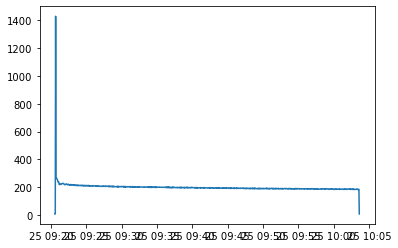

In [179]:
print(f"Longitud {len(fridge_activation[146])}")
print(fridge_activation[146])
plt.plot(fridge_activation[146])

In [190]:
#Elimino los esas posiciones de las huellas del dispositivo
print(f"Activaciones {len(fridge_activation)}")
#Al eliminar un indice se cambia en una posicion el indice
#Despues de la primera eliminación paso del indice 146 a ser el 145
cont = 0
for i in posicion_mayor:
    print(i)
    fridge_activation.pop(i-cont)
    cont += 1
print(f"Activaciones {len(fridge_activation)}")

Activaciones 727
118
146
178
203
388
439
478
509
681
684
694
711
Activaciones 715


Longitud 11
2011-04-25 08:10:09-04:00     6.0
2011-04-25 08:10:12-04:00     7.0
2011-04-25 08:10:15-04:00    46.0
2011-04-25 08:10:18-04:00    46.0
2011-04-25 08:10:21-04:00    46.0
2011-04-25 08:10:24-04:00    46.0
2011-04-25 08:10:27-04:00    46.0
2011-04-25 08:10:30-04:00     6.0
2011-04-25 08:10:33-04:00     6.0
2011-04-25 08:10:36-04:00    46.0
2011-04-25 08:10:39-04:00     7.0
Freq: 3S, Name: (power, active), dtype: float32


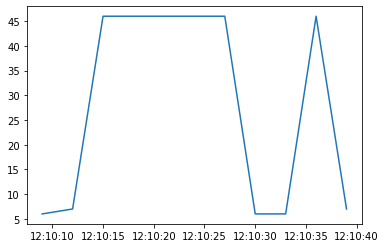

In [193]:
i = 147
print(f"Longitud {len(fridge_activation[i])}")
print(fridge_activation[i])
plt.plot(fridge_activation[i])

Ahora relleno las señales con menor tamaño al maximo elegido con ceros para poder mantener una longitud unica en el tamaño de las señales tanto de entrada medidor central como en la salida medidor distribuido.

In [196]:
#umbral = 800 puntos maximos de una señal
umbral = 800
señal_activacion_fridge = np.zeros([len(fridge_activation), umbral])
#Llenemos las señales de cada dispositivo en matriz con igual numero de filas
for i in range(len(fridge_activation)):
    #print(i)
    señal_activacion_fridge[i][0:len(fridge_activation[i])] = fridge_activation[i]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Ahora necesitamos hacer lo mismo para las señales del medidor central. Usaremos los indices del medidor de dispositivo para hacer un corte similar.

Requiero los datos de inicio y fin de la activacion seleccionados para hacer los cortes en los mismos instantes de tiempo en el medidor central. 

In [263]:
#Tiempos Huellas seleccionadas
tiempos_fridge = []
for j in range(len(fridge_activation)):    
    inicio = fridge_activation[j].index[0]             
    fin    = fridge_activation[j].index[len(fridge_activation[j])-1]
    tiempos_fridge.append([inicio, fin])

In [264]:
dir_seleccionadas = 'C:\\Users\\josel\\nilmtk_work\\NILMTK_Repaso\\Huellas_Seleccionadas_h1\\'
tiempos_fridge = pd.DataFrame(tiempos_fridge)
tiempos_fridge.to_csv(dir_seleccionadas+"tiempos_fridge.csv")
#Para trabajar como datos de tiempo cambio el formato
tiempos_fridge[0] = pd.to_datetime(tiempos_fridge[0])
tiempos_fridge[1] = pd.to_datetime(tiempos_fridge[1])
print(f"{tiempos_fridge.shape}")

(715, 2)


In [269]:
señales_fridge_medidor_0 = []
señales_fridge_medidor_1 = []
for i in range(tiempos_fridge.shape[0]):
    inicio = tiempos_fridge[0][i]
    fin    = tiempos_fridge[1][i]
    print(f"inicio {inicio} fin {fin}")
    señales_fridge_medidor_0.append(mean_0.loc[inicio:fin, 'power'].values)
    señales_fridge_medidor_1.append(mean_1.loc[inicio:fin, 'power'].values)
    #print(mean_0.loc[inicio:fin, 'power'])
#señales_fridge_medidor_0

inicio 2011-04-18 10:17:36-04:00 fin 2011-04-18 10:42:57-04:00
inicio 2011-04-18 11:00:36-04:00 fin 2011-04-18 11:37:09-04:00
inicio 2011-04-18 11:44:18-04:00 fin 2011-04-18 11:44:45-04:00
inicio 2011-04-18 12:26:51-04:00 fin 2011-04-18 12:43:18-04:00
inicio 2011-04-18 13:25:30-04:00 fin 2011-04-18 13:39:24-04:00
inicio 2011-04-18 14:25:42-04:00 fin 2011-04-18 14:39:27-04:00
inicio 2011-04-18 15:05:21-04:00 fin 2011-04-18 15:23:45-04:00
inicio 2011-04-18 16:12:24-04:00 fin 2011-04-18 16:29:06-04:00
inicio 2011-04-18 17:38:12-04:00 fin 2011-04-18 17:57:39-04:00
inicio 2011-04-18 18:33:30-04:00 fin 2011-04-18 18:50:51-04:00
inicio 2011-04-18 18:54:51-04:00 fin 2011-04-18 18:55:27-04:00
inicio 2011-04-18 20:10:51-04:00 fin 2011-04-18 20:32:06-04:00
inicio 2011-04-18 21:14:03-04:00 fin 2011-04-18 21:14:30-04:00
inicio 2011-04-18 21:22:54-04:00 fin 2011-04-18 21:40:36-04:00
inicio 2011-04-18 21:59:57-04:00 fin 2011-04-18 22:00:30-04:00
inicio 2011-04-18 22:54:18-04:00 fin 2011-04-18 23:19:0

inicio 2011-04-26 23:49:36-04:00 fin 2011-04-27 00:12:39-04:00
inicio 2011-04-27 01:35:18-04:00 fin 2011-04-27 01:57:39-04:00
inicio 2011-04-27 03:21:12-04:00 fin 2011-04-27 03:40:33-04:00
inicio 2011-04-27 05:03:51-04:00 fin 2011-04-27 05:25:42-04:00
inicio 2011-04-27 06:46:27-04:00 fin 2011-04-27 07:08:21-04:00
inicio 2011-04-27 08:14:45-04:00 fin 2011-04-27 08:36:33-04:00
inicio 2011-04-27 08:42:15-04:00 fin 2011-04-27 08:42:42-04:00
inicio 2011-04-27 10:04:24-04:00 fin 2011-04-27 10:28:03-04:00
inicio 2011-04-27 11:46:27-04:00 fin 2011-04-27 12:09:21-04:00
inicio 2011-04-27 13:30:15-04:00 fin 2011-04-27 13:53:51-04:00
inicio 2011-04-27 15:11:45-04:00 fin 2011-04-27 15:35:33-04:00
inicio 2011-04-27 16:55:54-04:00 fin 2011-04-27 17:20:30-04:00
inicio 2011-04-27 18:13:12-04:00 fin 2011-04-27 18:38:12-04:00
inicio 2011-04-27 20:10:12-04:00 fin 2011-04-27 20:34:51-04:00
inicio 2011-04-27 21:49:54-04:00 fin 2011-04-27 22:13:33-04:00
inicio 2011-04-27 23:28:27-04:00 fin 2011-04-27 23:51:5

inicio 2011-05-10 03:06:45-04:00 fin 2011-05-10 03:28:45-04:00
inicio 2011-05-10 04:33:51-04:00 fin 2011-05-10 04:55:36-04:00
inicio 2011-05-10 06:03:57-04:00 fin 2011-05-10 06:26:12-04:00
inicio 2011-05-10 07:31:24-04:00 fin 2011-05-10 07:57:21-04:00
inicio 2011-05-10 09:04:39-04:00 fin 2011-05-10 09:27:21-04:00
inicio 2011-05-10 10:37:27-04:00 fin 2011-05-10 11:00:15-04:00
inicio 2011-05-10 12:13:06-04:00 fin 2011-05-10 12:35:36-04:00
inicio 2011-05-10 13:49:15-04:00 fin 2011-05-10 14:11:30-04:00
inicio 2011-05-10 15:25:48-04:00 fin 2011-05-10 15:47:57-04:00
inicio 2011-05-10 17:02:36-04:00 fin 2011-05-10 17:25:03-04:00
inicio 2011-05-10 18:39:00-04:00 fin 2011-05-10 19:01:39-04:00
inicio 2011-05-10 20:16:00-04:00 fin 2011-05-10 20:38:33-04:00
inicio 2011-05-10 21:52:51-04:00 fin 2011-05-10 22:15:21-04:00
inicio 2011-05-10 23:29:36-04:00 fin 2011-05-10 23:51:54-04:00
inicio 2011-05-11 01:06:30-04:00 fin 2011-05-11 01:28:30-04:00
inicio 2011-05-11 02:43:30-04:00 fin 2011-05-11 03:05:1

inicio 2011-05-19 03:45:27-04:00 fin 2011-05-19 03:56:48-04:00
inicio 2011-05-19 04:37:33-04:00 fin 2011-05-19 04:48:51-04:00
inicio 2011-05-19 05:40:42-04:00 fin 2011-05-19 05:53:09-04:00
inicio 2011-05-19 06:31:30-04:00 fin 2011-05-19 06:42:36-04:00
inicio 2011-05-19 07:22:06-04:00 fin 2011-05-19 07:37:24-04:00
inicio 2011-05-19 08:36:00-04:00 fin 2011-05-19 08:55:03-04:00
inicio 2011-05-19 09:45:57-04:00 fin 2011-05-19 09:59:45-04:00
inicio 2011-05-19 10:39:06-04:00 fin 2011-05-19 10:51:15-04:00
inicio 2011-05-19 11:32:09-04:00 fin 2011-05-19 11:44:12-04:00
inicio 2011-05-19 12:25:42-04:00 fin 2011-05-19 12:37:42-04:00
inicio 2011-05-19 13:19:39-04:00 fin 2011-05-19 13:31:39-04:00
inicio 2011-05-19 14:13:54-04:00 fin 2011-05-19 14:26:00-04:00
inicio 2011-05-19 15:08:27-04:00 fin 2011-05-19 15:20:39-04:00
inicio 2011-05-19 15:59:45-04:00 fin 2011-05-19 16:18:24-04:00
inicio 2011-05-19 16:35:39-04:00 fin 2011-05-19 17:14:03-04:00
inicio 2011-05-19 17:51:30-04:00 fin 2011-05-19 18:07:5

Ahora que tengo las señales del medidor central debo pasarlas a ventanas de igual longitud que las del medidor distribuido. Para ello tengo en cuenta que el medidor central mide cada 1s y el distribuido cada 3s. Lo que se hace es tomar las medidas del medidor central cada 3 posiciones y descartar las demas.

In [322]:
#Eliminaremos las señales tomadas en mayor frecuencia para que sean iguales a las del medidor central
señales_fridge_medidor_0_igualado = []
señales_fridge_medidor_1_igualado = []
#Selecciona la fila o señal
for i in range(len(señales_fridge_medidor_0)):
    #LLeno los valores por señal
    medida_0= []
    medida_1= []
    #Recorre la fila o señal
    #print(f"Señal inicial {len(señales_fridge_medidor_0[i])}")
    for j in range(0,len(señales_fridge_medidor_0[i]), 3):
        #print(j)
        medida_0.append(señales_fridge_medidor_0[i][j])
        medida_1.append(señales_fridge_medidor_1[i][j])        
    #print(f"Señal final {len(medida_0)}")
    #print("*"*9)
    señales_fridge_medidor_0_igualado.append(medida_0)
    señales_fridge_medidor_1_igualado.append(medida_1)

In [323]:
#Verifico que los resultados sean coincidentes entre las señales
i = 2
print(f"Medidor central inicial {len(señales_fridge_medidor_0[i])}")
print(f"Medidor central reducido {len(señales_fridge_medidor_0_igualado[i])}")
print(f"Señal refrigerador {len(fridge_activation[i])}")

Medidor central inicial 28
Medidor central reducido 10
Señal refrigerador 10


Ahora procedo a igualar las entradas de los medidores centrales como se hizo con las del medidor central

In [325]:
#umbral = 800 puntos maximos de una señal
umbral = 800
señal_activacion_fridge_mean_0 = np.zeros([len(señales_fridge_medidor_0_igualado), umbral])
señal_activacion_fridge_mean_1 = np.zeros([len(señales_fridge_medidor_1_igualado), umbral])
#Ambos medidore tienene el mismo numero de señales
#Llenemos las señales de cada dispositivo en matriz con igual numero de filas
for i in range(len(señales_fridge_medidor_0_igualado)):
    #print(i)
    #señal_activacion_fridge[i][0:len(fridge_activation[i])] = fridge_activation[i]
    
    señal_activacion_fridge_mean_0[i][0:len(señales_fridge_medidor_0_igualado[i])] = señales_fridge_medidor_0_igualado[i]
    señal_activacion_fridge_mean_1[i][0:len(señales_fridge_medidor_1_igualado[i])] = señales_fridge_medidor_1_igualado[i]

**NOTA**: Terminado este proces ya tenemos las señales de activació  para los medidores centrales **señal_activacion_fridge_mean_0** y **señal_activacion_fridge_mean_1** que seran las entradas de nuestro modelo X, su salida correspondiente sera **señal_activacion_fridge** osea Y. 

## Crear el modelo autoencoder para predicción
La idea es obtener en la salida del auto encoder una señal similar a las del medidor distribuido, si se logra este proceso podemos usar un umbral para indicar en que momentos clasificamos la señal como encendida o apagada.

In [332]:
X_1 = señal_activacion_fridge_mean_0.copy()
X_2 = señal_activacion_fridge_mean_1.copy()
y = señal_activacion_fridge.copy()

In [338]:
print(f"{X_1.shape}")
print(f"{X_2.shape}")
print(f"{y.shape}")

(715, 800)
(715, 800)
(715, 800)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [340]:
#Función para guardar los datos en ventanas de tiempo
def guardar_arrays(datos, nombre = "X"):
    df = pd.DataFrame(datos)
    df.to_csv(nombre+".csv")

guardar_arrays(X_1, "X1_AE")
guardar_arrays(X_2, "X2_AE")
guardar_arrays(y, "y_AE")

## Normalización de los datos

In [341]:
# Defino una función de escalado de los datos entre 0 y 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

In [342]:
# Escalo los datos de los medidores X_1, X_2 medidor 1 y medidor 2
X_data1_scaled = sc.fit_transform(X_1)
X_data2_scaled = sc.fit_transform(X_2)
y_data_scaled = sc.fit_transform(y)
print(f"X_data1_scaled {X_data1_scaled.shape}")
print(f"X_data2_scaled {X_data2_scaled.shape}")
print(f"y_data_scaled {y_data_scaled.shape}")

X_data1_scaled (715, 800)
X_data2_scaled (715, 800)
y_data_scaled (715, 800)


## Dividir los datos en train y test

In [345]:
X = data2D #Potencia medidores 1 y 2 
y =  np.array(y_data_scaled)     #Etiquetas Para el refrigerador
#Dividiendo el conjunto de datos
trainX, testX, trainy, testy = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(f'trainX {trainX.shape}, testX{testX.shape}, trainy{trainy.shape}, testy{testy.shape}')

trainX (572, 800, 2), testX(143, 800, 2), trainy(572, 800), testy(143, 800)


## Modelo LSTM AE

In [347]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [351]:
# prepare sequence
length = 800

X = trainX
y = trainy
# define LSTM configuration
n_neurons = length
n_batch = 100
n_epoch = 20
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 2)))
model.add(Dense(length))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(testX, batch_size=n_batch, verbose=0)
for value in result[0,:]:
    print('%.1f' % value)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 800)               2569600   
_________________________________________________________________
dense_2 (Dense)              (None, 800)               640800    
Total params: 3,210,400
Trainable params: 3,210,400
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
6/6 - 104s - loss: 0.1020
Epoch 2/20
6/6 - 98s - loss: 0.0520
Epoch 3/20
6/6 - 100s - loss: 0.0386
Epoch 4/20
6/6 - 100s - loss: 0.0297
Epoch 5/20
6/6 - 100s - loss: 0.0279
Epoch 6/20
6/6 - 99s - loss: 0.0269
Epoch 7/20
6/6 - 113s - loss: 0.0266
Epoch 8/20
6/6 - 140s - loss: 0.0264
Epoch 9/20
6/6 - 172s - loss: 0.0262
Epoch 10/20
6/6 - 181s - loss: 0.0261
Epoch 11/20
6/6 - 187s - loss: 0.0262
Epoch 12/20
6/6 - 192s - loss: 0.0262
Epoch 13/20
6/6 - 188s - loss: 0.0261
Epoch 14/20
6/6 - 

## Modelo LSTM AE con wrapper TimeDistributed para el análisis

In [361]:
from numpy import array
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
# define input sequence
n_in = 800
X = trainX
y = trainy

# define el model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,2)))
model.add(RepeatVector(n_in))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit modelo
model.fit(X, y, epochs=50, verbose=2)
# conecte el codificador LSTM como capa de salida
model = Model(inputs=model.inputs, outputs=model.layers[0].output)
#plot_model(model, show_shapes=True, to_file='lstm_encoder.png')
model.summary()

Epoch 1/50
18/18 - 14s - loss: 0.0679
Epoch 2/50
18/18 - 13s - loss: 0.0554
Epoch 3/50
18/18 - 14s - loss: 0.0549
Epoch 4/50
18/18 - 14s - loss: 0.0548
Epoch 5/50
18/18 - 13s - loss: 0.0549
Epoch 6/50
18/18 - 13s - loss: 0.0548
Epoch 7/50
18/18 - 14s - loss: 0.0549
Epoch 8/50
18/18 - 14s - loss: 0.0547
Epoch 9/50
18/18 - 16s - loss: 0.0546
Epoch 10/50
18/18 - 15s - loss: 0.0547
Epoch 11/50
18/18 - 14s - loss: 0.0545
Epoch 12/50
18/18 - 15s - loss: 0.0547
Epoch 13/50
18/18 - 14s - loss: 0.0545
Epoch 14/50
18/18 - 14s - loss: 0.0544
Epoch 15/50
18/18 - 14s - loss: 0.0546
Epoch 16/50
18/18 - 13s - loss: 0.0548
Epoch 17/50
18/18 - 13s - loss: 0.0545
Epoch 18/50
18/18 - 14s - loss: 0.0547
Epoch 19/50
18/18 - 13s - loss: 0.0547
Epoch 20/50
18/18 - 14s - loss: 0.0545
Epoch 21/50
18/18 - 14s - loss: 0.0544
Epoch 22/50
18/18 - 14s - loss: 0.0541
Epoch 23/50
18/18 - 13s - loss: nan
Epoch 24/50
18/18 - 14s - loss: nan
Epoch 25/50
18/18 - 14s - loss: nan
Epoch 26/50
18/18 - 14s - loss: nan
Epoch 2

In [ ]:
# Evaluación
result = model.predict(X, batch_size=n_batch, verbose=0)
for value in result[0,:,0]:
    print('%.1f' % value)

In [ ]:
#***************************************************

In [369]:
from numpy import array
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
# define input sequence
n_in = 800
X = trainX
y = y

# define el model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,2)))
model.add(RepeatVector(n_in))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
model.summary()
# fit modelo
model.fit(X, y, epochs=50, verbose=2)
# conecte el codificador LSTM como capa de salida
model = Model(inputs=model.inputs, outputs=model.layers[0].output)
#plot_model(model, show_shapes=True, to_file='lstm_encoder.png')
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 100)               41200     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 800, 100)          0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 800, 100)          80400     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 800, 1)            101       
Total params: 121,701
Trainable params: 121,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
18/18 - 18s - loss: 0.0691
Epoch 2/50
18/18 - 18s - loss: 0.0552
Epoch 3/50
18/18 - 18s - loss: 0.0548
Epoch 4/50
18/18 - 17s - loss: 0.0550
Epoch 5/50
18/18 - 18s - loss: 0.0550
Epoch 6/50
18/18 - 18s - loss: 0.0549
Epoch 7/50
18/18 

In [ ]:
# Evaluación
result = model.predict(X, batch_size=n_batch, verbose=0)
for value in result[0,:,0]:
    print('%.1f' % value)

## Cambiar los datos a ventanas de tiempo

In [16]:
#La funcion requiere un df, datos a predecir, datos en cada ventana, datos a solaparse
#Requiere el indice definida con una serie de uno en uno 0,1,2...
def ventana_tiempo(dataset, n_steps_out=1, n_steps_in = 1, overlap = 1,feature = 0):
    #Matriz de datos
    dataX = []
    #Como los datos se corren debo controlar no sobrepasar la cantida de datos
    tem = n_steps_in + n_steps_out - overlap
    for i in range(int((len(dataset) - tem)/overlap)):
        #Corte de datos en el df original
        startx = i*overlap             #Inicio datos X
        endx = startx + n_steps_in     #Fin datos X
        #Datos de la ventana
        a = dataset.iloc[startx:endx, feature].values.astype('int')
        dataX.append(a)
    return np.array(dataX)
    #return dataX

Transformación de las señales de los medidores centrales mean_0 y mean_1

In [17]:
print(f"main_1h3 {mean_0.shape}")
print(f"tipo {type(mean_0)}")

n_steps_out = 1 # Solo lo uso si requiero prediccion
n_steps_in = 700 # Datos en la ventana
overlap = 100    # Datos a traslapar
feature = 1     # Columna o caracteristica a seleccionar en este caso la potencia
X_1 = ventana_tiempo(mean_0, n_steps_out, n_steps_in, overlap, 0)
X_2 = ventana_tiempo(mean_1, n_steps_out, n_steps_in, overlap, 0)

main_1h3 (1561660, 1)
tipo <class 'pandas.core.frame.DataFrame'>


In [18]:
len(X_1)

15610

In [ ]:
#Función para guardar los datos en ventanas de tiempo
def guardar_arrays(datos, nombre = "X"):
    df = pd.DataFrame(datos)
    df.to_csv(nombre+".csv")

guardar_arrays(X_1, "X1_edificio_1")
guardar_arrays(X_2, "X2_edificio_1")

In [ ]:
guardar_arrays(X_1, "X1_edificio_1")
guardar_arrays(X_2, "X2_edificio_1")

#### Etiqutado de marcas de activación

Tambien debemos hacer la transformación de las etiquetas se debe pasar cada columna de activaciones. Se deben mantener las mismas condiciones de fabricación para que las etiquetas conincidan en instantes de tiempo similar. 

In [12]:
#Función para renombrar las etiquetas de activacion
#Requiere el df con los nombres de las columnas
#Retorna un diccionario donde la clave es la columna 
#y el valor es el nombre de columna
def nombres_columnas(label_edificio):
    nombres = {}
    l = np.array(label_edificio)
    for i in range(1, len(label_edificio)+1):
        nombres[i] = l[i-1][0][10:]
    return nombres

In [13]:
#Cargemos los datos de etiquetas de dispositivos del edificio 1
#Definimos las rutas de los archivos
edificio = 1
pad_etiquetas = "C://Users//josel//nilmtk_work//NILMTK_Repaso//"
etiquetas_edificio_1 = "etiquetas_edificio_"+str(edificio)+".csv"
#Cargamos los nombres de las columnas
label = pd.read_csv(pad_huellas[edificio-1]+"label.txt", header=None)
Y = pd.read_csv(pad_etiquetas+etiquetas_edificio_1, sep=r",", header= None, index_col=0)
Y.drop([len(label)+1], axis=1, inplace=True)
Y.head(4)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,,,,,,,,,,,,,,,,,,
2011-04-18 09:22:09-04:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-04-18 09:22:10-04:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-04-18 09:22:11-04:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-04-18 09:22:12-04:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
#Renombrar las columnas
columnas = nombres_columnas(label)
Y.rename(columns=columnas, inplace=True)

In [ ]:
#Crearemos las ventanas de tiempo por dispositivo:
n_steps_out = 1 # Solo lo uso si requiero prediccion
n_steps_in = 700 # Datos en la ventana
overlap = 100    # Datos a traslapar
feature = 1     # Columna o caracteristica a seleccionar en este caso la potencia
Y_1 = ventana_tiempo(Y.iloc[:,:1], n_steps_out, n_steps_in, overlap, 0)
Y_2 = ventana_tiempo(Y.iloc[:,1:2], n_steps_out, n_steps_in, overlap, 0)
Y_3 = ventana_tiempo(Y.iloc[:,2:3], n_steps_out, n_steps_in, overlap, 0)
Y_4 = ventana_tiempo(Y.iloc[:,3:4], n_steps_out, n_steps_in, overlap, 0)
Y_5 = ventana_tiempo(Y.iloc[:,4:5], n_steps_out, n_steps_in, overlap, 0)
Y_6 = ventana_tiempo(Y.iloc[:,5:6], n_steps_out, n_steps_in, overlap, 0)
Y_7 = ventana_tiempo(Y.iloc[:,6:7], n_steps_out, n_steps_in, overlap, 0)
Y_8 = ventana_tiempo(Y.iloc[:,7:8], n_steps_out, n_steps_in, overlap, 0)
Y_9 = ventana_tiempo(Y.iloc[:,8:9], n_steps_out, n_steps_in, overlap, 0)
Y_10 = ventana_tiempo(Y.iloc[:,9:10], n_steps_out, n_steps_in, overlap, 0)
Y_11 = ventana_tiempo(Y.iloc[:,10:11], n_steps_out, n_steps_in, overlap, 0)
Y_12 = ventana_tiempo(Y.iloc[:,11:12], n_steps_out, n_steps_in, overlap, 0)
Y_13 = ventana_tiempo(Y.iloc[:,12:13], n_steps_out, n_steps_in, overlap, 0)
Y_14 = ventana_tiempo(Y.iloc[:,13:14], n_steps_out, n_steps_in, overlap, 0)
Y_15 = ventana_tiempo(Y.iloc[:,14:15], n_steps_out, n_steps_in, overlap, 0)
Y_16 = ventana_tiempo(Y.iloc[:,15:16], n_steps_out, n_steps_in, overlap, 0)
Y_17 = ventana_tiempo(Y.iloc[:,16:17], n_steps_out, n_steps_in, overlap, 0)
Y_18 = ventana_tiempo(Y.iloc[:,17:18], n_steps_out, n_steps_in, overlap, 0)

In [ ]:
#Verifico que todos tengan el mismo tamaño de ventana
'''
print(f"Y_1 = {len(Y_1)} type {type(Y_1)}")
print(f"Y_2 = {len(Y_2)} type {type(Y_2)}")
print(f"Y_3 = {len(Y_3)} type {type(Y_3)}")
print(f"Y_4 = {len(Y_4)} type {type(Y_4)}")
print(f"Y_5 = {len(Y_5)} type {type(Y_5)}")
print(f"Y_6 = {len(Y_6)} type {type(Y_6)}")
print(f"Y_7 = {len(Y_7)} type {type(Y_7)}")
print(f"Y_8 = {len(Y_8)} type {type(Y_8)}")
print(f"Y_9 = {len(Y_9)} type {type(Y_9)}")
print(f"Y_10 = {len(Y_10)} type {type(Y_10)}")
print(f"Y_11 = {len(Y_11)} type {type(Y_11)}")
print(f"Y_12 = {len(Y_12)} type {type(Y_12)}")
print(f"Y_13 = {len(Y_13)} type {type(Y_13)}")
print(f"Y_14 = {len(Y_14)} type {type(Y_14)}")
print(f"Y_15 = {len(Y_15)} type {type(Y_15)}")
print(f"Y_16 = {len(Y_16)} type {type(Y_16)}")
print(f"Y_17 = {len(Y_17)} type {type(Y_17)}")
print(f"Y_18 = {len(Y_18)} type {type(Y_18)}")
'''

In [ ]:
guardar_arrays(Y_1 , nombre = "Y_1")
guardar_arrays(Y_2 , nombre = "Y_2")
guardar_arrays(Y_3 , nombre = "Y_3")
guardar_arrays(Y_4 , nombre = "Y_4")
guardar_arrays(Y_5 , nombre = "Y_5")
guardar_arrays(Y_6 , nombre = "Y_6")
guardar_arrays(Y_7 , nombre = "Y_7")
guardar_arrays(Y_8 , nombre = "Y_8")
guardar_arrays(Y_9 , nombre = "Y_9")
guardar_arrays(Y_10 , nombre = "Y_10")
guardar_arrays(Y_11 , nombre = "Y_11")
guardar_arrays(Y_12 , nombre = "Y_12")
guardar_arrays(Y_13 , nombre = "Y_13")
guardar_arrays(Y_14 , nombre = "Y_14")
guardar_arrays(Y_15 , nombre = "Y_15")
guardar_arrays(Y_16 , nombre = "Y_16")
guardar_arrays(Y_17 , nombre = "Y_17")
guardar_arrays(Y_18 , nombre = "Y_18")

Es necesario que para cada señal solo le corresponda una sola marca de encendido o apagado. El creiterio para definir si un dispositivo esta encendido u apagado que si mas del 25% de los datos de la marca estan en 1 se marque la señal como encendida, en caso contrario se indique que el dispositivo se encontaba apagado. Nuestras ventanas son de 700 pasos. Por lo tanto si tengo 700*0.25 = 175 puntos en 1 diremos que el dispositivo se encontraba encendido. 

In [15]:
# Convertir la etiqueta de una serie de datos a una salida unica, requiere las señales en formato de ventana
import collections
def marca_unica(y, porcentaje_encendidos = 0.25):
    if(len(y) > 0):
        encendidos = round(len(y[0])*porcentaje_encendidos)
        y_label = []
        for i in range(len(y)):
            coleccion = collections.Counter(y[i])
            if coleccion[1] >= encendidos:
                y_label.append([1])
                #print(i)
            else:
                y_label.append([0])
        return y_label
    else:
        print("Sin señales")

In [ ]:
y_1 = marca_unica(Y_1)
y_2 = marca_unica(Y_2)
y_3 = marca_unica(Y_3)
y_4 = marca_unica(Y_4)
y_5 = marca_unica(Y_5)
y_6 = marca_unica(Y_6)
y_7 = marca_unica(Y_7)
y_8 = marca_unica(Y_8)
y_9 = marca_unica(Y_9)
y_10 = marca_unica(Y_10)
y_11 = marca_unica(Y_11)
y_12 = marca_unica(Y_12)
y_13 = marca_unica(Y_13)
y_14 = marca_unica(Y_14)
y_15 = marca_unica(Y_15)
y_16 = marca_unica(Y_16)
y_17 = marca_unica(Y_17)
y_18 = marca_unica(Y_18)

In [ ]:
#Guardar marcas unicas de activo o inactivo
guardar_arrays(y_1 , nombre = "y_1")
guardar_arrays(y_2 , nombre = "y_2")
guardar_arrays(y_3 , nombre = "y_3")
guardar_arrays(y_4 , nombre = "y_4")
guardar_arrays(y_5 , nombre = "y_5")
guardar_arrays(y_6 , nombre = "y_6")
guardar_arrays(y_7 , nombre = "y_7")
guardar_arrays(y_8 , nombre = "y_8")
guardar_arrays(y_9 , nombre = "y_9")
guardar_arrays(y_10 , nombre = "y_10")
guardar_arrays(y_11 , nombre = "y_11")
guardar_arrays(y_12 , nombre = "y_12")
guardar_arrays(y_13 , nombre = "y_13")
guardar_arrays(y_14 , nombre = "y_14")
guardar_arrays(y_15 , nombre = "y_15")
guardar_arrays(y_16 , nombre = "y_16")
guardar_arrays(y_17 , nombre = "y_17")
guardar_arrays(y_18 , nombre = "y_18")

In [ ]:
etiqueta_unica = 'C://Users//josel//nilmtk_work//NILMTK_Repaso//Etiquetas_unicas//bulding1'

# Construcción del modelo

### 1. Normalización de los datos

In [16]:
# Defino una función de escalado de los datos entre 0 y 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

In [17]:
X_1 = pd.read_csv("C://Users//josel//nilmtk_work//NILMTK_Repaso//X1_edificio_1.csv", header=0, index_col=0)
X_2 = pd.read_csv("C://Users//josel//nilmtk_work//NILMTK_Repaso//X2_edificio_1.csv", header=0, index_col=0)

In [24]:
y_3 = pd.read_csv("C://Users//josel//nilmtk_work//NILMTK_Repaso//Etiquetas_unicas//bulding1//y_3.csv", 
                  header=0, index_col=0)

In [18]:
# Escalo los datos de los medidores X_1, X_2 medidor 1 y medidor 2
X_data1_scaled = sc.fit_transform(X_1)
X_data2_scaled = sc.fit_transform(X_2)
print(f"X_data1_scaled {X_data1_scaled.shape}")
print(f"X_data2_scaled {X_data2_scaled.shape}")

## Uno las entradas de los dos medidores como un tensor

In [343]:
from numpy import dstack
data2D = list()         #Creo una lista iterable para unir BD
data2D.append(X_data1_scaled) #Agrego la BD de corriente 1 en frecuencias
data2D.append(X_data2_scaled)  #Agrego la BD de corriente 1

data2D = dstack(data2D) #Crea una concatenación atravéz de los ejes 2D
#data2D_c1h3 = np.reshape(data2D_c1h3, (data2D_c1h3.shape[2], data2D_c1h3.shape[0], data2D_c1h3.shape[1]))

print(data2D.shape)
print(type(data2D))

(715, 800, 2)
<class 'numpy.ndarray'>


## Crear el modelo en redes neuronales

In [344]:
#Creando el modelo
# cnn modelo
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import os

#Dividir los datos en entrenamiento y prueba
#import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\h5py\__init__.py:40: UserWarning: h5py is running against HDF5 1.10.6 when it was built against 1.10.5, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [ ]:
X = data2D #Potencia medidores 1 y 2 
y =  np.array(y_3)     #Etiquetas Para el refrigerador
#Dividiendo el conjunto de datos
trainX, testX, trainy, testy = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(f'trainX {trainX.shape}, testX{testX.shape}, trainy{trainy.shape}, testy{testy.shape}')

## Valancear las muestras
Los dispositivos se encuentran mas tiempo en estado de apagado que encendido, para valancear las muestras dode el dispositivo se encuentra encendido tomaremos contaremos en cuantas de las señales se encuentra encendido el dispositivo y en cuantas no, la idea es tener un numero valanceado de datos encendidos y apagados.

In [26]:
len(y_3)

15610

In [28]:
y_3 = y_3.to_numpy()

In [29]:
#1. Contar del total de señales en cuantas se tiene como encendido el dispositivo refrigerador y_3.
encendidos = 0
apagados = 0
otros = 0
id_encendido = [] #Guardo la posición de los datos encendidos
id_apagados = [] #Guardo la posición de los datos apagados
for i in range(len(y_3)):
    if (y_3[i][0] == 1):
        encendidos += 1
        id_encendido.append(i)
    elif (y_3[i][0] == 0):
        apagados += 1
        id_apagados.append(i)
    else:
        otros += 1
print(f"Totales = {len(y_3)} Encendidos = {encendidos} Apagados {apagados} otros {otros} {encendidos + apagados}")

Totales = 15610 Encendidos = 5113 Apagados 10497 otros 0 15610


In [30]:
#2. Separar señales del dispositivo encendido 5113 señales
refrigerador_encendido1 = []
refrigerador_encendido2 = []
i = 0

for i in range(len(id_encendido)):
    refrigerador_encendido1.append(X_data1_scaled[id_encendido[i]])
    refrigerador_encendido2.append(X_data2_scaled[id_encendido[i]])

In [31]:
len(refrigerador_encendido2)

5113

In [32]:
#3. Separar señales del dispositivo apagado 5113 señales
import random
refrigerador_apagado = []
#Buscar una señal del dispositivo apagado de forma aleatoria
for i in range(5113):
    # Tomar una señal aleatoria entre la señal 0 y 10496
    id = random.randint(0, 10496)
    refrigerador_apagado.append(X_data1_scaled[id_apagados[id]])

In [33]:
main_refrigerador_1 = refrigerador_encendido1 + refrigerador_apagado
main_refrigerador_2 = refrigerador_encendido2 + refrigerador_apagado

In [34]:
#Crear una lista con las etiquetas de encendido y apagado
y_refrigerador = np.zeros([10226, 1],  dtype = np.int8)
y_refrigerador[:5112] = 1 #La primer mitad es de señales de encendido

In [35]:
#Convierto a df los tres datos para poder unirlos en uno solo
main_refrigerador_1 = pd.DataFrame(main_refrigerador_1)
main_refrigerador_2 = pd.DataFrame(main_refrigerador_2)
y_refrigerador = pd.DataFrame(y_refrigerador)

In [36]:
#Etiqueto las columnas para despues poder mezclar los datos
main_refrigerador_1['y'] = y_refrigerador[0]
main_refrigerador_2['y'] = y_refrigerador[0]

In [37]:
#Creo una lista con el mismo numero de filas de 0 a 10225
#Luego mezclo estos datos y sera con ellas que tomare el nuevo
#orden en los dos medidores
id = [i for i in range(0,10226)]
#Des organizar los valores de la lista:
random.shuffle(id)

In [38]:
#Con esta lista re ordeno las señales manteniento el orden en los dos medidores
X_main_1 = pd.DataFrame()
X_main_2 = pd.DataFrame()

for i in id:
    X_main_1 = X_main_1.append(main_refrigerador_1.iloc[id[i],:])
    X_main_2 = X_main_2.append(main_refrigerador_2.iloc[id[i],:])

In [39]:
X_main_1

,0,1,2,3,4,5,6,7,8,9,...,691,692,693,694,695,696,697,698,699,y
3023,0.047735,0.047528,0.047752,0.047345,0.047436,0.047362,0.047445,0.047528,0.047744,0.047519,...,0.000697,0.000697,0.000868,0.001042,0.000868,0.000696,0.000868,0.001041,0.000869,1.0
3941,0.000697,0.000524,0.000700,0.000524,0.000698,0.000522,0.000523,0.000524,0.000525,0.000524,...,0.031174,0.031168,0.031435,0.031266,0.031413,0.031326,0.030908,0.031071,0.031120,1.0
9808,0.013415,0.013629,0.013469,0.012753,0.013080,0.013059,0.013605,0.013105,0.012942,0.012928,...,0.012887,0.012711,0.012852,0.013028,0.013016,0.012704,0.012676,0.012845,0.012691,0.0
2672,0.047735,0.047702,0.047927,0.047694,0.047436,0.047710,0.047445,0.047528,0.048094,0.047519,...,0.044932,0.045273,0.045328,0.044989,0.044950,0.045249,0.045320,0.045305,0.044854,1.0
9459,0.013240,0.013105,0.013469,0.013103,0.013080,0.013059,0.013082,0.013105,0.013116,0.013103,...,0.013062,0.013059,0.013546,0.013896,0.013884,0.013053,0.013197,0.013192,0.013561,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9504,0.013937,0.013280,0.013469,0.013452,0.013777,0.013234,0.013082,0.014153,0.013291,0.013277,...,0.013236,0.014104,0.014067,0.013375,0.013363,0.013227,0.013891,0.013886,0.013213,0.0
1204,0.046167,0.046304,0.046353,0.046296,0.046041,0.046143,0.045875,0.046304,0.046345,0.046296,...,0.013758,0.013756,0.013894,0.013896,0.013884,0.013749,0.013891,0.013886,0.013561,1.0
9182,0.025784,0.025686,0.026238,0.026205,0.025985,0.025771,0.025815,0.026035,0.026058,0.026031,...,0.026123,0.026293,0.026051,0.025534,0.025859,0.025409,0.026220,0.026384,0.025730,0.0
6489,0.013415,0.013280,0.013469,0.013277,0.013254,0.013234,0.013257,0.013280,0.013291,0.013277,...,0.013410,0.013059,0.013373,0.013375,0.013363,0.013227,0.013197,0.013366,0.013039,0.0


In [40]:
X_main_2

,0,1,2,3,4,5,6,7,8,9,...,691,692,693,694,695,696,697,698,699,y
3023,0.000668,0.000669,0.000672,0.000670,0.000668,0.000836,0.000668,0.000669,0.000669,0.000669,...,0.000665,0.000666,0.000668,0.000666,0.000667,0.000664,0.000669,0.000670,0.000668,1.0
3941,0.000835,0.000836,0.000840,0.000837,0.000836,0.001003,0.000835,0.000836,0.000837,0.000836,...,0.008805,0.007824,0.007850,0.007660,0.007672,0.007806,0.007694,0.007867,0.007846,1.0
9808,0.013415,0.013629,0.013469,0.012753,0.013080,0.013059,0.013605,0.013105,0.012942,0.012928,...,0.012887,0.012711,0.012852,0.013028,0.013016,0.012704,0.012676,0.012845,0.012691,0.0
2672,0.035404,0.035446,0.035624,0.035487,0.035261,0.035595,0.035422,0.035434,0.035475,0.035452,...,0.190065,0.190611,0.191415,0.191007,0.190627,0.189503,0.191169,0.191496,0.190985,1.0
9459,0.013240,0.013105,0.013469,0.013103,0.013080,0.013059,0.013082,0.013105,0.013116,0.013103,...,0.013062,0.013059,0.013546,0.013896,0.013884,0.013053,0.013197,0.013192,0.013561,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9504,0.013937,0.013280,0.013469,0.013452,0.013777,0.013234,0.013082,0.014153,0.013291,0.013277,...,0.013236,0.014104,0.014067,0.013375,0.013363,0.013227,0.013891,0.013886,0.013213,0.0
1204,0.000167,0.000167,0.000168,0.000167,0.000167,0.000334,0.000167,0.000167,0.000167,0.000167,...,0.000166,0.000166,0.000167,0.000167,0.000167,0.000166,0.000167,0.000167,0.000167,1.0
9182,0.025784,0.025686,0.026238,0.026205,0.025985,0.025771,0.025815,0.026035,0.026058,0.026031,...,0.026123,0.026293,0.026051,0.025534,0.025859,0.025409,0.026220,0.026384,0.025730,0.0
6489,0.013415,0.013280,0.013469,0.013277,0.013254,0.013234,0.013257,0.013280,0.013291,0.013277,...,0.013410,0.013059,0.013373,0.013375,0.013363,0.013227,0.013197,0.013366,0.013039,0.0


In [41]:
#Compruebo si las dos etiquetas de y Son iguales
X_main_1.loc[:,"y"] == X_main_2.loc[:,"y"]

3023    True
3941    True
9808    True
2672    True
9459    True
        ... 
9504    True
1204    True
9182    True
6489    True
5490    True
Name: y, Length: 10226, dtype: bool

In [42]:
#Ahora separa los datos de las columnas de marcas al ser igual solo requiero de uno
y_3 = X_main_1.iloc[:,700:701].astype(int)
y_3 = y_3.to_numpy()

In [43]:
#Elimino las columnas de etiquetado
X_main_1.drop("y",axis=1, inplace=True)
X_main_2.drop("y",axis=1, inplace=True)

In [44]:
#Guardo los datos como arrays para mejorar el rendimiento del calculo con tensores
X_data1_scaled = X_main_1.to_numpy()
X_data2_scaled = X_main_2.to_numpy()

In [45]:
X_main_1.to_csv("X_1_save.csv")
X_main_2.to_csv("X_2_save.csv")
y_3.to_csv("y_3_save.csv")

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [46]:
y_3 = pd.DataFrame(y_3)
y_3.to_csv("y_3_save.csv")

## Unir las entradas en un tensor de dos dimensiones
Las redes LSTM requieren que la estructura de la información que se les entregue mantenga la forma: [# muestras, # muestras en un paso de tiempo, # caracteristicas]. Para lograr esta estructura en los datos concatenaremos en dimensión los datos para la potencia agregada provenientes de los dos medidores centrales. 

In [ ]:
from numpy import dstack
data2D = list()         #Creo una lista iterable para unir BD
data2D.append(X_data1_scaled) #Agrego la BD de corriente 1 en frecuencias
data2D.append(X_data2_scaled)  #Agrego la BD de corriente 1

data2D = dstack(data2D) #Crea una concatenación atravéz de los ejes 2D
#data2D_c1h3 = np.reshape(data2D_c1h3, (data2D_c1h3.shape[2], data2D_c1h3.shape[0], data2D_c1h3.shape[1]))

print(data2D.shape)
print(type(data2D))
#data2D.to_csv(directory+'\\data2D\\house_3\\corriente1h3f2D.csv', sep=' ')

### Crear el modelo de redes neuronales

In [ ]:
#Creando el modelo
# cnn modelo
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import os

#Dividir los datos en entrenamiento y prueba
#import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
X = data2D #Potencia medidores 1 y 2 
y =  np.array(y_3)     #Etiquetas Para el refrigerador
#Dividiendo el conjunto de datos
trainX, testX, trainy, testy = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(f'trainX {trainX.shape}, testX{testX.shape}, trainy{trainy.shape}, testy{testy.shape}')

In [ ]:
#Creando el primer modelo
verbose, epochs, batch_size = 1, 250, 512
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
modela = Sequential()
modela.add(Conv1D(filters=20, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
modela.add(Dropout(0.5))
modela.add(Conv1D(filters=10, kernel_size=3, activation='relu'))
modela.add(Dropout(0.5))
modela.add(MaxPooling1D(pool_size=2))
modela.add(Flatten())
modela.add(Dense(100, activation='relu'))
modela.add(Dense(100, activation='relu'))
modela.add(Dense(n_outputs, activation='softmax'))
modela.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
y_preda = modela.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracya = modela.evaluate(testX, testy, batch_size=batch_size, verbose=0)

In [ ]:
#*******************************************************
#*******************No borrar aun **********************
#*******************************************************

In [ ]:
df_etiquetado = pd.concat([mean_0,mean_1], axis = 1)
df_etiquetado

In [ ]:
#Concatenar con las etiquetas
#Primero cargo el archivo de etiquetas edificio 1
pad_df_etiquetas = "C:\\Users\\josel\\nilmtk_work\\NILMTK_Repaso\\"
df_etiquetas = pd.read_csv(pad_df_etiquetas+"etiquetas_edificio_1.csv", sep=r",", header=None, index_col=0)

In [ ]:
df_etiquetas_ed_1 = pd.concat([df_etiquetado,df_etiquetas], axis = 1)
df_etiquetas_ed_1

In [ ]:
df_etiquetas_ed_1.to_csv("edificio_1_union_etiquetas.csv", sep=r" ", header=0)

## Crear los datos en ventanas de tiempo
Se deben crear los datos en ventanas para entregarlos a la red como entradas

In [ ]:
id_edificio = 1
medidor = 0
mean = pd.read_csv(rutas_archivos_originales[id_edificio-1][medidor],header=[0,1])#, index_col=0)
#Tomar solo los valores
mean = mean.iloc[0:,:].values        
#Convertir a dataframe
mean = pd.DataFrame(mean)
#Cambiar el nombre de las columnas
mean.rename(columns={0:'time', 1:'power'}, inplace=True)
#Cambiar a datos en formato de tiempo que faciliten las busquedas de intervalos
mean['time'] = pd.to_datetime(mean['time'])
mean.set_index('time', inplace= True)

In [ ]:
mean.index

In [ ]:
#Cargamos los nombres de los dispositivos por edificio este es del 1
label = pd.read_csv(pad_huellas[0]+"label.txt", header=None)
label

In [ ]:
dispositivo = 0
label.iloc[dispositivo,0][10:]

In [ ]:
#Creamos una matriz de ceros con una columna mas ademas de los dispositivos
df = np.zeros([len(mean.index), len(label)+1], dtype = np.int8)
#Lo cambio a un df de pandas
df = pd.DataFrame(df)
#Cambio el nombre de las columnas
nombre_columnas = {0:'time'}
for i in range(1,len(label)):
    nombre_columnas[i] = label.iloc[i-1,0][10:]

df.rename(columns=nombre_columnas, inplace=True)

#Igualamos la columna de tiempo del df de etiquetas con el del medidor
df['time'] = mean.index

#Cambiar a datos en formato de tiempo que faciliten las busquedas de intervalos
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace= True)
df


In [ ]:
#Ahora vamos a igualar a uno los instantes donde se activo un dispositivo
#para eso usamos las huellas que se han separado antes

#Cargamos las huella del primer dispositivo
edificio = 0
dispositivo = 0
huella = pd.read_csv(pad_huellas[edificio]+label.iloc[dispositivo,0]+".csv", sep=r" ", header=None, index_col=0)
huella

In [ ]:
#Ahora a la columna del primer dispositivo igualamos a uno donde conincidan los tiempos de activación
dispositivo = 0
#Selecciona la señal
i= 0
df.loc[huella.iloc[i,0]:huella.iloc[i,1],label.iloc[dispositivo,0][10:]] = 1

In [ ]:
df.to_csv("borrar_xxxx.csv")

In [ ]:
huella

In [ ]:
#1. Seleccionamos los mejores tiempos de funcionamiento para el refrigerador de la casa 1
good_sections_fridge = fridge.good_sections(full_results=True)
good_sections_fridge.timeframes()
good_sections_fridge.plot()

In [ ]:
#2. Ver las secciones exactas del refrigerador
good_sections_fridge.combined()

In [ ]:
#***********************************

In [ ]:
#3. Seleccionamos los mejores tiempos de funcionamiento para el lavaplatos de la casa 1
good_sections_dishwaser = dishwaser.good_sections(full_results=True)
good_sections_dishwaser.timeframes()
good_sections_dishwaser.plot()

In [ ]:
#4. Ver las secciones exactas del refrigerador
good_sections_dishwaser.combined()

In [ ]:
#*************************************

In [ ]:
#5. Cargamos los datos para el medidor central
mean1 = edificio_1.mains()[1]
#6. Seleccionamos los mejores tiempos de funcionamiento para el medidor central de la casa 1
good_sections_mean1 = mean1.good_sections(full_results=True)
good_sections_mean1.timeframes()
good_sections_mean1.plot()

In [ ]:
tiempos_mean1 = good_sections_mean1.combined()

In [ ]:
len(tiempos_mean1)

In [ ]:
#******************************************

In [ ]:
#7. Cargamos los datos para el medidor central 2
mean2 = edificio_1.mains()[2]
#8. Seleccionamos los mejores tiempos de funcionamiento para el medidor central de la casa 1
good_sections_mean2 = mean2.good_sections(full_results=True)
good_sections_mean2.timeframes()
good_sections_mean2.plot()

In [ ]:
tiempos_mean2 = good_sections_mean2.combined()

In [ ]:
len(tiempos_mean2)

## Unir datos
Debemos tomar muestras donde el medidor central este funcionando de manera adecuada.

De esta manera garantizamos que el entrenamiento se haga en instantes de tiempo donde las medidas sean adecuadas.

Contruimos una nueva base de datos en la que solo tendremos en cuenta las etapas de buen funcionamiento para los medidores centrales 1 y 2. 

In [ ]:
#Cargamos las bases de datos para los dos medidores centrales y los 
#converimos a dataframe para que sea mas facil su procesamoento

c1_mean1 = pd.read_csv('C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building1//elec//meter1.csv', 
                              header=[0,1])#, index_col=0)
c1_mean1 = c1_mean1.iloc[0:,:].values
c1_mean1 = pd.DataFrame(c1_mean1)
c1_mean1.rename(columns={0:'time', 1:'power'}, inplace=True)
#Cambiar a datos en formato de tiempo
c1_mean1['time'] = pd.to_datetime(c1_mean1['time'])
c1_mean1.set_index('time', inplace= True)
c1_mean1

In [ ]:
#Para el medidor 2
c1_mean2 = pd.read_csv('C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building1//elec//meter2.csv', 
                              header=[0,1])#, index_col=0)
c1_mean2 = c1_mean2.iloc[0:,:].values
c1_mean2 = pd.DataFrame(c1_mean2)
c1_mean2.rename(columns={0:'time', 1:'power'}, inplace=True)
#Cambiar a datos en formato de tiempo
c1_mean2['time'] = pd.to_datetime(c1_mean2['time'])
c1_mean2.set_index('time', inplace= True)
c1_mean2

El indice de los dos archivos se ha dejado a modo de timestamp para poder hacer cortes basados en los tiempos de buen funcionamiento antes calculados usando NILMTK.

Para ingresar a los valores se toma como una lista en la cual cada celda puede retornar el tiempo de inicio y fin usando los metodos .start  y .end

In [ ]:
print(tiempos_mean1[0].start)
print(tiempos_mean1[1].end)

In [ ]:
prueba = c1_mean1.copy()

In [ ]:
c1_mean1_nuevo

In [ ]:
#Hay que unir un total de 26 intervalos donde el medidor central funcino
#de manera correctay descartar el resto de los tiempos
c1_mean1_nuevo = pd.concat([prueba.loc[tiempos_mean1[0].start: tiempos_mean1[0].end], 
                            prueba.loc[tiempos_mean1[1].start: tiempos_mean1[1].end],                            
                            prueba.loc[tiempos_mean1[2].start: tiempos_mean1[2].end],
                            prueba.loc[tiempos_mean1[3].start: tiempos_mean1[3].end],
                            prueba.loc[tiempos_mean1[4].start: tiempos_mean1[4].end],
                            prueba.loc[tiempos_mean1[5].start: tiempos_mean1[5].end],
                            prueba.loc[tiempos_mean1[6].start: tiempos_mean1[6].end],
                            prueba.loc[tiempos_mean1[7].start: tiempos_mean1[7].end],
                            prueba.loc[tiempos_mean1[8].start: tiempos_mean1[8].end],
                            prueba.loc[tiempos_mean1[9].start: tiempos_mean1[9].end],
                            prueba.loc[tiempos_mean1[10].start: tiempos_mean1[10].end],
                            prueba.loc[tiempos_mean1[11].start: tiempos_mean1[11].end],
                            prueba.loc[tiempos_mean1[12].start: tiempos_mean1[12].end],
                            prueba.loc[tiempos_mean1[13].start: tiempos_mean1[13].end],
                            prueba.loc[tiempos_mean1[14].start: tiempos_mean1[14].end],
                            prueba.loc[tiempos_mean1[15].start: tiempos_mean1[15].end],
                            prueba.loc[tiempos_mean1[16].start: tiempos_mean1[16].end],
                            prueba.loc[tiempos_mean1[17].start: tiempos_mean1[17].end],
                            prueba.loc[tiempos_mean1[18].start: tiempos_mean1[18].end],
                            prueba.loc[tiempos_mean1[19].start: tiempos_mean1[19].end],
                            prueba.loc[tiempos_mean1[20].start: tiempos_mean1[20].end],
                            prueba.loc[tiempos_mean1[21].start: tiempos_mean1[21].end],
                            prueba.loc[tiempos_mean1[22].start: tiempos_mean1[22].end],
                            prueba.loc[tiempos_mean1[23].start: tiempos_mean1[23].end],
                            prueba.loc[tiempos_mean1[24].start: tiempos_mean1[24].end],
                            prueba.loc[tiempos_mean1[25].start: tiempos_mean1[25].end]
                           ])

In [ ]:
print(
len(prueba.loc[tiempos_mean1[0].start: tiempos_mean1[0].end]), 
len(prueba.loc[tiempos_mean1[1].start: tiempos_mean1[1].end]),                            
len(prueba.loc[tiempos_mean1[2].start: tiempos_mean1[2].end]),
len(prueba.loc[tiempos_mean1[3].start: tiempos_mean1[3].end]),
len(prueba.loc[tiempos_mean1[4].start: tiempos_mean1[4].end]),
len(prueba.loc[tiempos_mean1[5].start: tiempos_mean1[5].end]),
len(prueba.loc[tiempos_mean1[6].start: tiempos_mean1[6].end]),
len(prueba.loc[tiempos_mean1[7].start: tiempos_mean1[7].end]),
len(prueba.loc[tiempos_mean1[8].start: tiempos_mean1[8].end]),
len(prueba.loc[tiempos_mean1[9].start: tiempos_mean1[9].end]),
len(prueba.loc[tiempos_mean1[10].start: tiempos_mean1[10].end]),
len(prueba.loc[tiempos_mean1[11].start: tiempos_mean1[11].end]),
len(prueba.loc[tiempos_mean1[12].start: tiempos_mean1[12].end]),
len(prueba.loc[tiempos_mean1[13].start: tiempos_mean1[13].end]),
len(prueba.loc[tiempos_mean1[14].start: tiempos_mean1[14].end]),
len(prueba.loc[tiempos_mean1[15].start: tiempos_mean1[15].end]),
len(prueba.loc[tiempos_mean1[16].start: tiempos_mean1[16].end]),
len(prueba.loc[tiempos_mean1[17].start: tiempos_mean1[17].end]),
len(prueba.loc[tiempos_mean1[19].start: tiempos_mean1[19].end]),
len(prueba.loc[tiempos_mean1[20].start: tiempos_mean1[20].end]),
len(prueba.loc[tiempos_mean1[21].start: tiempos_mean1[21].end]),
len(prueba.loc[tiempos_mean1[22].start: tiempos_mean1[22].end]),
len(prueba.loc[tiempos_mean1[23].start: tiempos_mean1[23].end]),
len(prueba.loc[tiempos_mean1[24].start: tiempos_mean1[24].end]),
len(prueba.loc[tiempos_mean1[25].start: tiempos_mean1[25].end])
)

print(
len(prueba.loc[tiempos_mean1[0].start: tiempos_mean1[0].end])+ 
len(prueba.loc[tiempos_mean1[1].start: tiempos_mean1[1].end])+                            
len(prueba.loc[tiempos_mean1[2].start: tiempos_mean1[2].end])+
len(prueba.loc[tiempos_mean1[3].start: tiempos_mean1[3].end])+
len(prueba.loc[tiempos_mean1[4].start: tiempos_mean1[4].end])+
len(prueba.loc[tiempos_mean1[5].start: tiempos_mean1[5].end])+
len(prueba.loc[tiempos_mean1[6].start: tiempos_mean1[6].end])+
len(prueba.loc[tiempos_mean1[7].start: tiempos_mean1[7].end])+
len(prueba.loc[tiempos_mean1[8].start: tiempos_mean1[8].end])+
len(prueba.loc[tiempos_mean1[9].start: tiempos_mean1[9].end])+
len(prueba.loc[tiempos_mean1[10].start: tiempos_mean1[10].end])+
len(prueba.loc[tiempos_mean1[11].start: tiempos_mean1[11].end])+
len(prueba.loc[tiempos_mean1[12].start: tiempos_mean1[12].end])+
len(prueba.loc[tiempos_mean1[13].start: tiempos_mean1[13].end])+
len(prueba.loc[tiempos_mean1[14].start: tiempos_mean1[14].end])+
len(prueba.loc[tiempos_mean1[15].start: tiempos_mean1[15].end])+
len(prueba.loc[tiempos_mean1[16].start: tiempos_mean1[16].end])+
len(prueba.loc[tiempos_mean1[17].start: tiempos_mean1[17].end])+
len(prueba.loc[tiempos_mean1[19].start: tiempos_mean1[19].end])+
len(prueba.loc[tiempos_mean1[20].start: tiempos_mean1[20].end])+
len(prueba.loc[tiempos_mean1[21].start: tiempos_mean1[21].end])+
len(prueba.loc[tiempos_mean1[22].start: tiempos_mean1[22].end])+
len(prueba.loc[tiempos_mean1[23].start: tiempos_mean1[23].end])+
len(prueba.loc[tiempos_mean1[24].start: tiempos_mean1[24].end])+
len(prueba.loc[tiempos_mean1[25].start: tiempos_mean1[25].end])
)

In [ ]:
#Guardar la base de datos
c1_mean1_nuevo.to_csv(pad_huellas+"c1_mean1_nuevo.csv", sep=r" ", header= 0)

In [ ]:
c1_mean1_nuevo


## Etiquetado de datos
Se crea un vector en el cual se etiquetara como 1 para señal activa para el dispositivo y 0 para señal apagada. De esta manera en pasos posteriores indicaremos los instantes en que un dispositivo esta encendido en las señales recopiladas del medidor central. 

In [ ]:
#Creo una columnna para etiquetar el refrigerador
c1_mean1_nuevo['fridge'] = 0

In [ ]:
c1_mean1_nuevo

In [ ]:
for i in range(len(huellas_0)):
    c1_mean1_nuevo.loc[huellas_0.iloc[i,0]:huellas_0.iloc[i,1],"fridge"] = 1

In [ ]:
#Guardar la base de datos
c1_mean1_nuevo.to_csv(pad_huellas+"c1_mean1_nuevo.csv", sep=r" ", header= 0)

In [ ]:
huellas_0.iloc[0,0]

In [ ]:
huellas_0.iloc[0,1]